In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
%cd STAT542/

/content/drive/MyDrive/STAT542


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import svm
import matplotlib as mpl


In [4]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [5]:
train_df = pd.read_csv('./fashion-mnist_train.csv')
test_df = pd.read_csv('./fashion-mnist_test.csv')

X_train, y_train, X_test, y_test = train_df.iloc[:,1:], train_df['label'], test_df.iloc[:,1:], test_df['label']


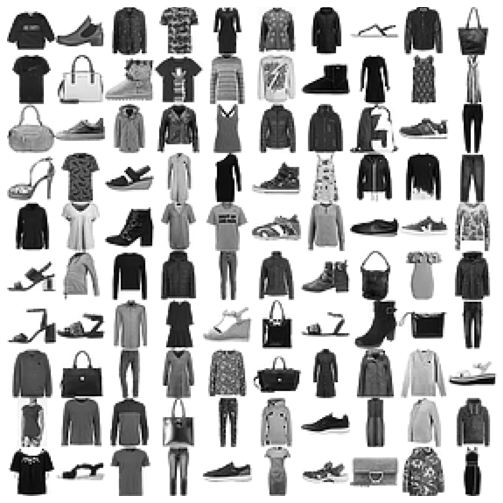

In [6]:
plt.figure(figsize=(9,9))
example_images = X_train[:100]
plot_digits(example_images.values, images_per_row=10)
plt.show()


In [7]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

PCA

Text(0.5, 0, 'Principal components')

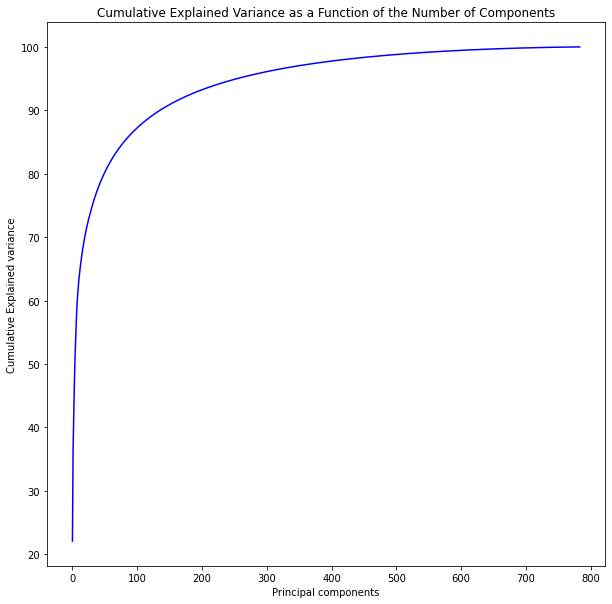

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_scaled)

X_train_PCA = pca.transform(X_train_scaled)
X_test_PCA = pca.transform(X_test_scaled)

cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(10, 10))
plt.plot(d,cumsum, color = 'blue',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')

In [9]:
def find_thresh_components(cum_variance, thresh):
    return np.argmax(np.where(cum_variance > thresh, 1, 0)) + 1

n_comp = find_thresh_components(cumsum, 90)

In [ ]:
def find_best_PCA_components(thresh, model, X, y, cum_variance):
    scores = []
    best_thresh = 0
    for i,t in enumerate(thresh):
        n_comp = find_thresh_components(cum_variance, t)
        X_train_PCA, y_train = X[0][:,:n_comp], y[0]
        X_test_PCA, y_test = X[1][:,:n_comp], y[1]
        model.fit(X_train_PCA, y_train)
        scores.append(model.score(X_test_PCA, y_test))
    return thresh[np.argmax(scores)], scores

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgbm

In [24]:
def EnsembleModel(models, features, final_model, X_train, y_train, X_test, y_test, model_names):
  preds_train = []
  preds_test = []
  col_names = []
  for i,m in enumerate(models):
    m.fit(X_train, y_train)
    if "proba" in features:
      preds_train.append(m.predict_proba(X_train).reshape(-1,1))
      preds_test.append(m.predict_proba(X_test).reshape(-1,1))
      col_names.append(f"{model_names[i]}_proba")
    if "predict" in features:
      preds_train.append(m.predict(X_train).reshape(-1,1))
      preds_test.append(m.predict(X_test).reshape(-1,1))
      col_names.append(f"{model_names[i]}_prediction")
    print(f"{model_names[i]} : {m.score(X_test, y_test)}")
  df_train = np.concatenate(preds_train, axis = 1)
  df_test = np.concatenate(preds_test, axis = 1)
  final_model.fit(df_train, y_train)
  return final_model.score(df_test, y_test)

In [13]:
#Base models with best parameters selected from previous section
rf_model = RandomForestClassifier(n_estimators=500)
knn_model = KNeighborsClassifier(n_neighbors = 5)
gbdt = lgbm.LGBMClassifier(n_estimators=1000, num_leaves = 40) 
lr_model = LogisticRegression(
    multi_class='multinomial', 
    max_iter=100,
    random_state=0, 
    fit_intercept=False,
    solver='lbfgs',
    tol=1e-3,
    C = 0.9
)
svm = SVC()
#EnsembleModel([rf_model, knn_model, gbdt], ["proba", "predict"], gbdt, X_train_PCA[:,:n_comp], y_train, X_test_PCA[:,:n_comp], y_test, ["rf", "knn", "gbdt"])

In [14]:
models = [rf_model, knn_model, gbdt, lr_model]
features =  ["predict"]
final_model = svm
model_names = ["rf", "knn", "gbdt", "lr"]

Train Base models and save their predictions

In [15]:
preds_train = []
preds_test = []
col_names = []
for i,m in enumerate(models):
  m.fit(X_train_PCA[:,:n_comp], y_train)
  if "proba" in features:
    preds_train.append(m.predict_proba(X_train_PCA[:,:n_comp]))
    preds_test.append(m.predict_proba(X_test_PCA[:,:n_comp]))
    col_names.append(f"{model_names[i]}_proba")
  if "predict" in features:
    preds_train.append(m.predict(X_train_PCA[:,:n_comp]).reshape(-1,1))
    preds_test.append(m.predict(X_test_PCA[:,:n_comp]).reshape(-1,1))
    col_names.append(f"{model_names[i]}_prediction")
  print(f"{model_names[i]} : {m.score(X_test_PCA[:,:n_comp], y_test)}")

rf : 0.8712
knn : 0.8714
gbdt : 0.8985
lr : 0.8527


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [16]:
#Function to make different type of datasets
def make_datasets(models, best_model, train, test, preds_train, preds_test, data_type = "A", with_preds = True):
  if data_type == "A":
    res_train = np.zeros((train.shape[0],10))
    res_test = np.zeros((test_df.shape[0],10))
    for m in models:
      prob_train = m.predict_proba(train)
      prob_test = m.predict_proba(test)
      res_train += prob_train
      res_test += prob_test 
    res_train = res_train/len(models)
    res_test = res_test/len(models)
    if with_preds:
      return np.concatenate((preds_train, res_train), axis = 1), np.concatenate((preds_test, res_test), axis = 1)
    else:
      return res_train, res_test
  if data_type == "B":
    rt = best_model.predict_proba(train)
    rte = best_model.predict_proba(test)
    res_train = np.concatenate((rt, preds_train),axis = 1)
    res_test = np.concatenate((rte, preds_test),axis = 1)
    if with_preds:
      return res_train, res_test 
    else:
      return rt, rte
  if data_type == "C" :
    return preds_train, preds_test
  if data_type == "D":
    res_train = np.concatenate((train[:,:16],preds_train),axis = 1)
    res_test = np.concatenate((test[:,:16],preds_test),axis = 1)
    return res_train, res_test


In [17]:
preds_train = np.concatenate(preds_train, axis = 1)
preds_test = np.concatenate(preds_test, axis = 1)

In [18]:
train, test = make_datasets(models, gbdt, X_train_PCA[:,:n_comp], X_test_PCA[:,:n_comp], preds_train, preds_test, "B", False)

In [19]:
train.shape

(60000, 10)

Tune final model using optuna

In [19]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 9.5 MB/s 
     |████████████████████████████████| 210 kB 55.1 MB/s 
     |████████████████████████████████| 78 kB 7.6 MB/s 
     |████████████████████████████████| 113 kB 57.4 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 146 kB 54.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=c4cb09ef4935938c6c17a8323e741c83658be8a8ac27680386c8c4c3a808fc69
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [21]:
import optuna
import sklearn
def tune_SVM(trial):
      C = trial.suggest_loguniform('C', 0.1, 100)
      kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])
      degree = trial.suggest_int('degree', 1, 15)
      clf = SVC(C=C, kernel=kernel)
      clf.fit(train, y_train)
      return clf.score(test, y_test)

In [107]:
study = optuna.create_study(direction='maximize')
study.optimize(tune_SVM, n_trials=50)

[I 2022-05-05 03:30:49,677] A new study created in memory with name: no-name-d1adb060-271a-4b80-8733-2129d4cd80cc
[I 2022-05-05 03:30:51,865] Trial 0 finished with value: 0.8607 and parameters: {'C': 24.702053132968835, 'kernel': 'linear', 'degree': 1}. Best is trial 0 with value: 0.8607.
[I 2022-05-05 03:30:54,060] Trial 1 finished with value: 0.8623 and parameters: {'C': 27.974038087574222, 'kernel': 'rbf', 'degree': 3}. Best is trial 1 with value: 0.8623.
[I 2022-05-05 03:31:11,267] Trial 2 finished with value: 0.7902 and parameters: {'C': 0.757832189665058, 'kernel': 'poly', 'degree': 7}. Best is trial 1 with value: 0.8623.
[I 2022-05-05 03:31:15,736] Trial 3 finished with value: 0.8594 and parameters: {'C': 0.5171068624917792, 'kernel': 'rbf', 'degree': 5}. Best is trial 1 with value: 0.8623.
[I 2022-05-05 03:31:17,867] Trial 4 finished with value: 0.8607 and parameters: {'C': 1.027163496801387, 'kernel': 'linear', 'degree': 10}. Best is trial 1 with value: 0.8623.
[I 2022-05-05 0

KeyboardInterrupt: ignored

In [108]:
def tune_knn(trial):
      neighbor = trial.suggest_int('n_neighbors', 3, 50)
      clf = KNeighborsClassifier(n_neighbors=neighbor)
      clf.fit(train, y_train)
      return clf.score(test, y_test)
study = optuna.create_study(direction='maximize')
study.optimize(tune_knn, n_trials=20)

[I 2022-05-05 03:31:28,289] A new study created in memory with name: no-name-5579fb8d-629b-4cd7-bd55-6ce108f56c11
[I 2022-05-05 03:31:30,352] Trial 0 finished with value: 0.8737 and parameters: {'n_neighbors': 47}. Best is trial 0 with value: 0.8737.
[I 2022-05-05 03:31:32,196] Trial 1 finished with value: 0.8742 and parameters: {'n_neighbors': 22}. Best is trial 1 with value: 0.8742.
[I 2022-05-05 03:31:34,066] Trial 2 finished with value: 0.8742 and parameters: {'n_neighbors': 24}. Best is trial 1 with value: 0.8742.
[I 2022-05-05 03:31:37,514] Trial 3 finished with value: 0.8735 and parameters: {'n_neighbors': 45}. Best is trial 1 with value: 0.8742.
[I 2022-05-05 03:31:39,522] Trial 4 finished with value: 0.8741 and parameters: {'n_neighbors': 34}. Best is trial 1 with value: 0.8742.


KeyboardInterrupt: ignored

In [109]:
def tune_lgbm(trial):
      n_estimators = trial.suggest_int('n_estimators', 100, 1000)
      num_leaves = trial.suggest_int('num_leaves', 20,60)
      reg_alpha = trial.suggest_float('reg_alpha', 0.00001, 0.001)
      clf = lgbm.LGBMClassifier(n_estimators=n_estimators, reg_alpha = reg_alpha, num_leaves = num_leaves)
      clf.fit(train, y_train)
      return clf.score(test, y_test)

In [110]:
study = optuna.create_study(direction='maximize')
study.optimize(tune_lgbm, n_trials=50)

[I 2022-05-05 03:31:44,440] A new study created in memory with name: no-name-10ab9792-3477-4fc3-8c2c-8db4e3ecf75e
[I 2022-05-05 03:32:12,831] Trial 0 finished with value: 0.8732 and parameters: {'n_estimators': 825, 'num_leaves': 23, 'reg_alpha': 0.0007306298494707069}. Best is trial 0 with value: 0.8732.
[I 2022-05-05 03:32:32,790] Trial 1 finished with value: 0.8733 and parameters: {'n_estimators': 584, 'num_leaves': 28, 'reg_alpha': 0.00028293429420530534}. Best is trial 1 with value: 0.8733.
[I 2022-05-05 03:33:02,167] Trial 2 finished with value: 0.8731 and parameters: {'n_estimators': 884, 'num_leaves': 23, 'reg_alpha': 0.00014948179594548669}. Best is trial 1 with value: 0.8733.
[I 2022-05-05 03:33:13,040] Trial 3 finished with value: 0.8731 and parameters: {'n_estimators': 299, 'num_leaves': 45, 'reg_alpha': 0.0008313641507957208}. Best is trial 1 with value: 0.8733.
[I 2022-05-05 03:33:42,860] Trial 4 finished with value: 0.8732 and parameters: {'n_estimators': 914, 'num_leave

KeyboardInterrupt: ignored

In [20]:
#Fit a Multinomial NB model
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
gnb = MultinomialNB()
gnb.fit(train, y_train)
gnb.score(test, y_test)

0.8983

In [29]:
#get best model performance
from sklearn.utils.extmath import row_norms
def get_best_model_performance(preds, ys):
  res = []
  for i, row in enumerate(preds):
    if ys[i] in row:
      res.append(1)
    else:
      #print(preds[i], ys[i])
      res.append(0)
  return res

In [48]:
res = get_best_model_performance(preds_test, y_test)

In [49]:
sum(res)/len(res)

0.9378

In [46]:
#Perform voting by taking majority vote.
voting_train = np.array([np.bincount(row).argmax() for row in preds_train])
voting_test = np.array([np.bincount(row).argmax() for row in preds_test])

In [47]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_train, voting_train))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      6000
           1       1.00      1.00      1.00      6000
           2       0.92      0.99      0.96      6000
           3       0.97      0.98      0.98      6000
           4       0.96      0.95      0.96      6000
           5       0.99      1.00      1.00      6000
           6       0.99      0.82      0.90      6000
           7       0.98      1.00      0.99      6000
           8       1.00      0.99      0.99      6000
           9       1.00      0.98      0.99      6000

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000



In [120]:
print(classification_report(y_test, voting_test))
print(accuracy_score(y_test, voting_test))

              precision    recall  f1-score   support

           0       0.80      0.89      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.84      0.82      1000
           3       0.90      0.93      0.91      1000
           4       0.82      0.86      0.84      1000
           5       0.95      0.94      0.94      1000
           6       0.78      0.60      0.68      1000
           7       0.92      0.93      0.93      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

0.8878
